In [32]:
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM  # perform F test

import selective_recruitment.globals as gl
# import Functional_Fusion.Functional_Fusion.dataset as ds 

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [33]:
# setting the directories
behav_dir = 'A:\\data\\Cerebellum\\CerebellumWorkingMemory\\data\\fmri'
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'

# Analysis of Behvioral performance inside the scanner

## Working memory task

In [34]:
# get the behavioral dataframe
df = pd.read_csv(behav_dir + "/df_wm.tsv", sep = "\t")
D_wm = df[["isErrorM", "isError", "numErrors", "MnumErrors", "NMnumErrors"]]
D_wm["phase"] = df.exec
D_wm["load"] = df.load
D_wm["recall_dir"] = df.seqType
D_wm["sn"] = df.sn


d_phase = D_wm.phase.map({0:"enc", 1:"ret"})
d_load = df.load.map({2: "L2", 4: "L4", 6: "L6"})
d_recall = df.seqType.map({1: "F", 0: "B"})

D_wm["cond_name"] = d_phase+ d_load + d_recall

# isCorrectM = 1 if all memory digits are correct
D_wm["isCorrectM"] = 1 - D_wm["isErrorM"] 

# isCorrectTot = 1 if the whole secuence is correct
D_wm["isCorrectTot"] = 1 - D_wm["isError"]

# get the number of errors in the non-memory digits
D_wm["nonmemError"] = D_wm["numErrors"] - D_wm["MnumErrors"]

# isErrorNM = 1 if there is at least one error in the non-memory digits
D_wm["isErrorNM"] = (D_wm["nonmemError"] > 0)*1

# isCorrectNM = 1 if all non-memory digits are correct
D_wm["isCorrectNM"] = 1 - D_wm["isErrorNM"]

### Behavioral performance 

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
load            15.3600 2.0000 30.0000 0.0000
recall_dir       5.4470 1.0000 15.0000 0.0339
load:recall_dir  0.5661 2.0000 30.0000 0.5737



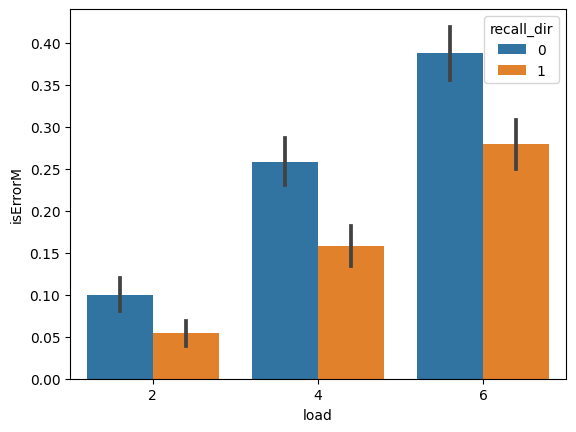

In [35]:
plotvar = "isErrorM"
sns.barplot(data = D_wm.loc[D_wm.phase == 1], x = "load", y =  plotvar, hue = "recall_dir", errorbar="se")
plt.savefig("wm_behaviour_percent_correct.pdf")
print(AnovaRM(data=D_wm.loc[(D_wm.phase == 1)], depvar=plotvar,subject='sn', within=['load', 'recall_dir'], aggregate_func=np.mean).fit())


### BOLD activation vs behavioral performance

In [36]:
# load data for the cerebellar parcellation
parcellation = "NettekovenSym32"
df_brain = pd.read_csv(Path(wkdir) / f"{parcellation}_df.csv", index_col = 0)

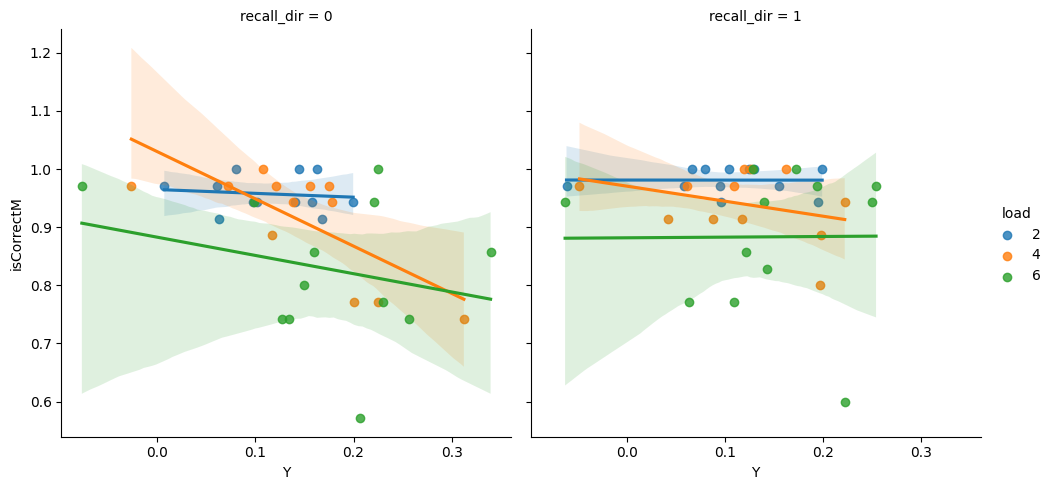

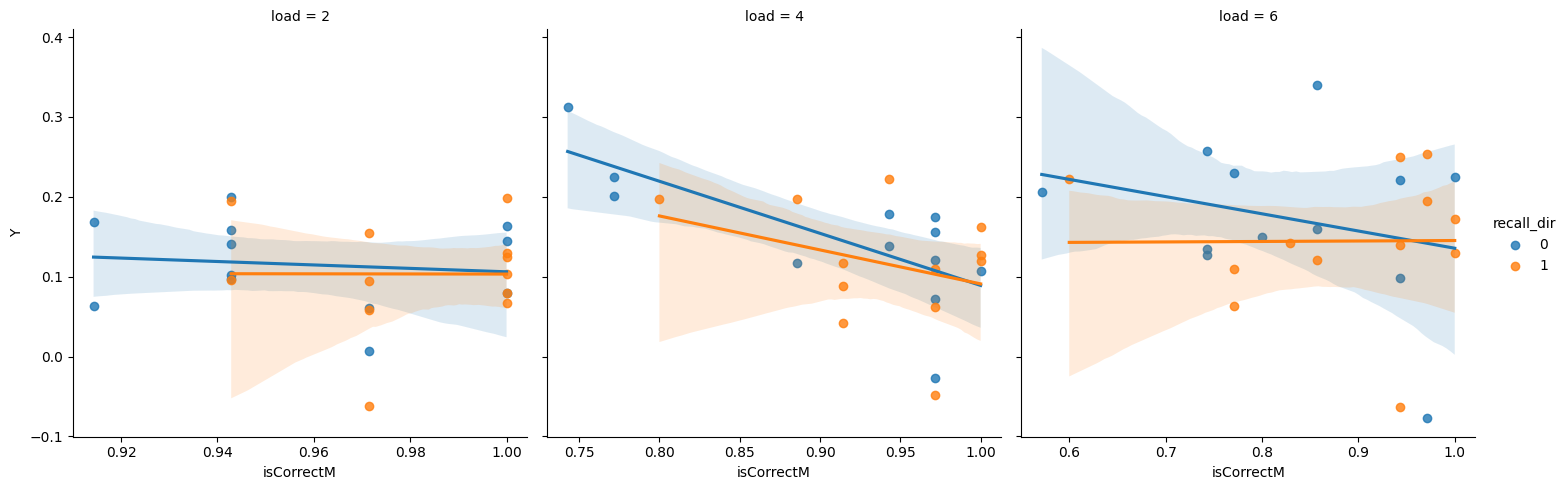

In [37]:
# get the activation for one selected region (within mmultiple demand network)
selected_df = df_brain.copy()
roi_name = "D3R"
plotvar = "isCorrectM"
df = selected_df.loc[(selected_df.cond_name != "rest") & (selected_df.roi_name == roi_name)]

# prep behavioral dataframe
grouped = D_wm.groupby(["sn", "load", "recall_dir"])
agg_kw = {
          plotvar:np.mean}
DD = grouped.agg(agg_kw)

# prep activation dataframe
grouped2 = df.groupby(["sn", 'load', 'recall'])
agg_kw = {
          'Y':np.mean,
          }
dff = grouped2.agg(agg_kw)
# make multilevel index into a new column
# dff.set_index(['load', 'recall'], inplace=True)

# Reset the multi-level index and convert it into a new column
dff.reset_index(inplace=True)
DD.reset_index(inplace=True)


dff["recall_dir"] = dff["recall"]

# merge the two dataframes by load and recall
D2 = pd.merge(DD, dff, on = ["sn", "load", "recall_dir"])

# # plot
sns.lmplot(data = D2, x = "Y", y = plotvar, hue = "load", col = "recall_dir", fit_reg = True)
# plot
sns.lmplot(data = D2, y = "Y", x = plotvar, hue= "recall_dir", col = "load", fit_reg = True, sharex=False)


# sns.scatterplot(
#     data=D2, x="isCorrectTot", y="Y", hue="load", style="recall_dir", palette="tab10"
# )